In [181]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

In [182]:
#Importing dataset and defining path variables
path = './data/'
file = 'master_data.csv'

df = pd.read_csv(path + file, index_col='ipoDate')
df

,index,employees,CEO_age,Name,Symbol,sector,IPO_weekday,firstday_volume,inweek_volume,Y_Open_Price,intra_day_up,intra_week_up,intra_month_up,SP500_lastweek_return,positive,negative,neutral
ipoDate,,,,,,,,,,,,,,,,,
2010-01-26,0,128.000000,57.460211,ANDATEE CHINA MARINE FUEL SERVICES CORP,AMCF,Energy,1,955563.0,5.878947e+06,6.500000,1,1,0,-0.007087,0.330000,0.330000,0.330000
2010-02-11,2,1486.000000,50.000000,GENERAC HOLDINGS INC.,GNRC,Industrials,3,16892087.0,2.179334e+06,13.000000,1,1,1,-0.003156,0.330000,0.330000,0.330000
2010-02-11,3,568.000000,62.000000,"QUINSTREET, INC",QNST,Technology,3,5372077.0,3.362175e+06,15.000000,0,1,0,-0.003156,0.330000,0.330000,0.330000
2010-02-10,4,6.000000,61.000000,TERRENO REALTY CORP,TRNO,Real Estate,2,4515261.0,7.616977e+05,18.750000,1,1,1,-0.002686,0.330000,0.330000,0.330000
2010-02-10,5,109.000000,59.000000,"PIEDMONT OFFICE REALTY TRUST, INC.",PDM,Real Estate,2,4343012.0,3.551568e+06,14.750000,1,1,1,-0.002686,0.330000,0.330000,0.330000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-03-22,3736,59.000000,58.000000,"ZAIS Group Holdings, Inc.",ZAIS,Finance,4,1511224.0,3.912183e+05,10.020000,0,0,0,0.000234,0.330000,0.330000,0.330000
2015-06-22,3739,7447.262841,54.787097,ProShares UltraPro Short NASDAQ Biotechnology,ZBIO,Other,0,0.0,1.593089e+05,41.900002,0,0,1,0.000964,0.063431,0.033641,0.902928
2011-07-20,3743,3181.000000,41.000000,"Zillow Group, Inc.",ZG,Miscellaneous,2,17549817.0,6.998521e+06,17.776737,1,1,1,0.000717,0.111890,0.263831,0.624278


In [183]:
#One hot encoding sector and weekday cols
categorical_cols = ['sector', 'IPO_weekday'] 
df = pd.get_dummies(df, columns = categorical_cols)

#Splitting into validity and training/test data
df_valid = df.loc[df.intra_day_up == 0].iloc[:25]
df_valid = pd.concat([df_valid, df.loc[(~df.Symbol.isin(df_valid.Symbol)) & (df.intra_day_up == 1)].copy()], axis = 0)

df = df.loc[~df.Symbol.isin(df_valid)].copy()

#Dropping Symbol, Name and Index columns
df.drop(columns=['Symbol', 'Name', 'index'], inplace=True, axis = 1)
df_valid.drop(columns=['Symbol', 'Name', 'index'], inplace=True, axis = 1)



In [184]:
#Normalizing numerical variables for ML modeling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

normalized_data_train = scaler.fit_transform(df)
normalized_data_valid = scaler.fit_transform(df_valid)
df_norm = pd.DataFrame(normalized_data_train, columns=df.columns)
df_valid = pd.DataFrame(normalized_data_valid, columns=df_valid.columns)

In [185]:
#Logistic Regression Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn import metrics

#Building completely unseen validity set
df_valid = df_norm.sample(100)
X_dv = df_valid.drop(columns= ['intra_day_up', 'intra_week_up', 'intra_month_up', 'firstday_volume', 'inweek_volume'])
X_wv = df_valid.drop(columns= ['intra_day_up', 'intra_week_up', 'intra_month_up', 'inweek_volume'])
X_mv = df_valid.drop(columns= ['intra_day_up', 'intra_week_up', 'intra_month_up'])
y_dv = np.array(df_valid.intra_day_up)
y_wv = np.array(df_valid.intra_week_up)
y_mv = np.array(df_valid.intra_month_up)

X_d = df_norm.drop(columns= ['intra_day_up', 'intra_week_up', 'intra_month_up', 'firstday_volume', 'inweek_volume'])
X_w = df_norm.drop(columns= ['intra_day_up', 'intra_week_up', 'intra_month_up', 'inweek_volume'])
X_m = df_norm.drop(columns= ['intra_day_up', 'intra_week_up', 'intra_month_up'])
y_d = np.array(df_norm.intra_day_up)
y_w = np.array(df_norm.intra_week_up)
y_m = np.array(df.intra_month_up)

#Looking at class imbalances
print('Class distribution: \n',df_norm[['intra_day_up','intra_week_up', 'intra_month_up']].mean())

Class distribution: 
 intra_day_up      0.692577
intra_week_up     0.697838
intra_month_up    0.659264
dtype: float64


In [186]:
#Dealing with class imbalances by oversampling minority class (underperforming IPOs)
sm = SMOTE(random_state=27)
X_d_bal, y_d_bal = sm.fit_resample(X_d, y_d)
X_w_bal, y_w_bal = sm.fit_resample(X_w, y_w)
X_m_bal, y_m_bal = sm.fit_resample(X_m, y_m)

#Printing mean of y values (should be 0.5, since data should now be balanced)
print('Class distribution after SMOTE: {:.2f}'.format(y_w_bal.mean()))

# setting up stratified testing and training sets
X_d_train, X_d_test, y_d_train, y_d_test = train_test_split(X_d_bal, y_d_bal, test_size=0.2, random_state=42, stratify = y_d_bal)
X_w_train, X_w_test, y_w_train, y_w_test = train_test_split(X_w_bal, y_w_bal, test_size=0.2, random_state=42, stratify = y_w_bal)
X_m_train, X_m_test, y_m_train, y_m_test = train_test_split(X_m_bal, y_m_bal, test_size=0.2, random_state=42, stratify = y_m_bal)

Class distribution after SMOTE: 0.50


In [187]:
#Fitting Logistic Regression Models
logreg_d = LogisticRegression()
logreg_w = LogisticRegression()
logreg_m = LogisticRegression()

logreg_d.fit(X_d_train, y_d_train)
logreg_w.fit(X_w_train, y_w_train)
logreg_m.fit(X_m_train, y_m_train)


LogisticRegression()

In [188]:
log_pred_d = logreg_d.predict(X_d_test)
log_pred_w = logreg_w.predict(X_w_test)
log_pred_m = logreg_m.predict(X_m_test)
print('Accuracy of logistic regression classifier on daily up test set: {:.2f}'.format(logreg_d.score(X_d_test, y_d_test)))
print('Accuracy of logistic regression classifier on weekly up test set: {:.2f}'.format(logreg_w.score(X_w_test, y_w_test)))
print('Accuracy of logistic regression classifier on monthly up test set: {:.2f}'.format(logreg_m.score(X_m_test, y_m_test)))

Accuracy of logistic regression classifier on daily up test set: 0.66
Accuracy of logistic regression classifier on weekly up test set: 0.68
Accuracy of logistic regression classifier on monthly up test set: 0.70


In [189]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


print(classification_report(y_d_test, log_pred_d))
confusion_matrix = confusion_matrix(y_d_test, log_pred_d)

#TN #FP
#FN #TP
print(confusion_matrix)



              precision    recall  f1-score   support

         0.0       0.62      0.79      0.70       237
         1.0       0.72      0.52      0.60       237

    accuracy                           0.66       474
   macro avg       0.67      0.66      0.65       474
weighted avg       0.67      0.66      0.65       474

[[188  49]
 [113 124]]


In [190]:
from sklearn.model_selection import RandomizedSearchCV
#Creating grid search for Random Forest Hyperparameter Tuning

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1500, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [191]:
from sklearn.ensemble import RandomForestClassifier
# Use the random grid to search for best hyperparameters
# First create the base models to tune for each predicted label
rf_d = RandomForestClassifier()
rf_w = RandomForestClassifier()
rf_m = RandomForestClassifier()

# Random search of parameters, using 10 fold cross validation, 
# search across 50 different combinations, and use all available cores
rf_random_d = RandomizedSearchCV(estimator = rf_d, param_distributions = random_grid, n_iter = 100, cv = 10, random_state=42, n_jobs = -1)
rf_random_w = RandomizedSearchCV(estimator = rf_w, param_distributions = random_grid, n_iter = 100, cv = 10, random_state=42, n_jobs = -1)
rf_random_m = RandomizedSearchCV(estimator = rf_m, param_distributions = random_grid, n_iter = 100, cv = 10, random_state=42, n_jobs = -1)

# Fit all random search models (Takes ca. 12 min to run)
rf_random_d.fit(X_d_train, y_d_train)

print('First randomized search completed.')

rf_random_w.fit(X_w_train, y_w_train)

print('Second randomized search completed.')

rf_random_m.fit(X_m_train, y_m_train)

First randomized search completed.
Second randomized search completed.


In [ ]:
#Evaluating accuracy of rf models
best_random_rf_d = rf_random_d.best_estimator_
best_random_rf_w = rf_random_w.best_estimator_
best_random_rf_m = rf_random_m.best_estimator_

#Creating random model predictions
rf_predictions_d = best_random_rf_d.predict(X_d_test)
rf_predictions_w = best_random_rf_w.predict(X_w_test)
rf_predictions_m = best_random_rf_m.predict(X_m_test)

#Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

print('Balanced accuracy of random forest classifier on daily up test set: {:.2f}'.format(balanced_accuracy_score(y_d_test, rf_predictions_d)))
print('Balanced accuracy of random forest classifier on weekly up test set: {:.2f}'.format(balanced_accuracy_score(y_w_test, rf_predictions_w)))
print('Balanced accuracy of random forest classifier on monthly up test set: {:.2f}'.format(balanced_accuracy_score(y_m_test, rf_predictions_m)))

Balanced accuracy of random forest classifier on daily up test set: 0.77
Balanced accuracy of random forest classifier on weekly up test set: 0.76
Balanced accuracy of random forest classifier on monthly up test set: 0.74


In [ ]:
from xgboost import XGBClassifier

#Creating XGB models for each predicted label
xgb_d = XGBClassifier(objective="binary:logistic")
xgb_w = XGBClassifier(objective="binary:logistic")
xgb_m = XGBClassifier(objective="binary:logistic")

#Defining search grid for randomized search
param_grid = {
    "max_depth": [int(x) for x in np.linspace(10, 200, num = 10)],
    "learning_rate": [0.1, 0.01, 0.05, 0.2, 0.25, 0.3],
    "gamma": [0, 0.1, 0.25, 0.5, 1],
    "reg_lambda": [0, 1, 2, 5, 10],
    "scale_pos_weight": [1, 2, 3, 4, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}

#Fitting randomized search to XGB models
xgb_random_d = RandomizedSearchCV(estimator = xgb_d, param_distributions = param_grid, n_iter = 100, cv = 10, random_state=42, n_jobs = -1)
xgb_random_w = RandomizedSearchCV(estimator = xgb_w, param_distributions = param_grid, n_iter = 100, cv = 10, random_state=42, n_jobs = -1)
xgb_random_m = RandomizedSearchCV(estimator = xgb_m, param_distributions = param_grid, n_iter = 100, cv = 10, random_state=42, n_jobs = -1)

#Fitting search to training data (Takes around 15 min to run)
xgb_random_d.fit(X_d_train, y_d_train)

print('First randomized search completed.')

xgb_random_w.fit(X_w_train, y_w_train)

print('Second randomized search completed.')

xgb_random_m.fit(X_m_train, y_m_train)

First randomized search completed.
Second randomized search completed.


RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rat...
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.5],
                                        'gamma': [0, 0.1, 0.25, 0.5, 1],
                                        'learning_rate': [0.1, 0.01, 0.05, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [10, 31, 52, 73, 94, 115,
                                                      136, 157, 178, 200],
                                        'reg_lambda': [0, 1, 2, 5, 10],
                                        'scale_pos_weight': [1, 2, 3, 4, 5],
                                        'subsample': [0.8]},
                   random_state=42)

In [ ]:
#Evaluating accuracy of xgb models
best_random_d = xgb_random_d.best_estimator_
best_random_w = xgb_random_w.best_estimator_
best_random_m = xgb_random_m.best_estimator_

#Creating random model predictions
xgb_predictions_d = best_random_d.predict(X_d_test)
xgb_predictions_w = best_random_w.predict(X_w_test)
xgb_predictions_m = best_random_m.predict(X_m_test)

#Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

print('Balanced accuracy of xgboost classifier on daily up test set: {:.2f}'.format(balanced_accuracy_score(y_d_test, xgb_predictions_d)))
print('Balanced accuracy of xgboost classifier on weekly up test set: {:.2f}'.format(balanced_accuracy_score(y_w_test, xgb_predictions_w)))
print('Balanced accuracy of xgboost classifier on monthly up test set: {:.2f}'.format(balanced_accuracy_score(y_m_test, xgb_predictions_m)))

Balanced accuracy of xgboost classifier on daily up test set: 0.72
Balanced accuracy of xgboost classifier on weekly up test set: 0.76
Balanced accuracy of xgboost classifier on monthly up test set: 0.77


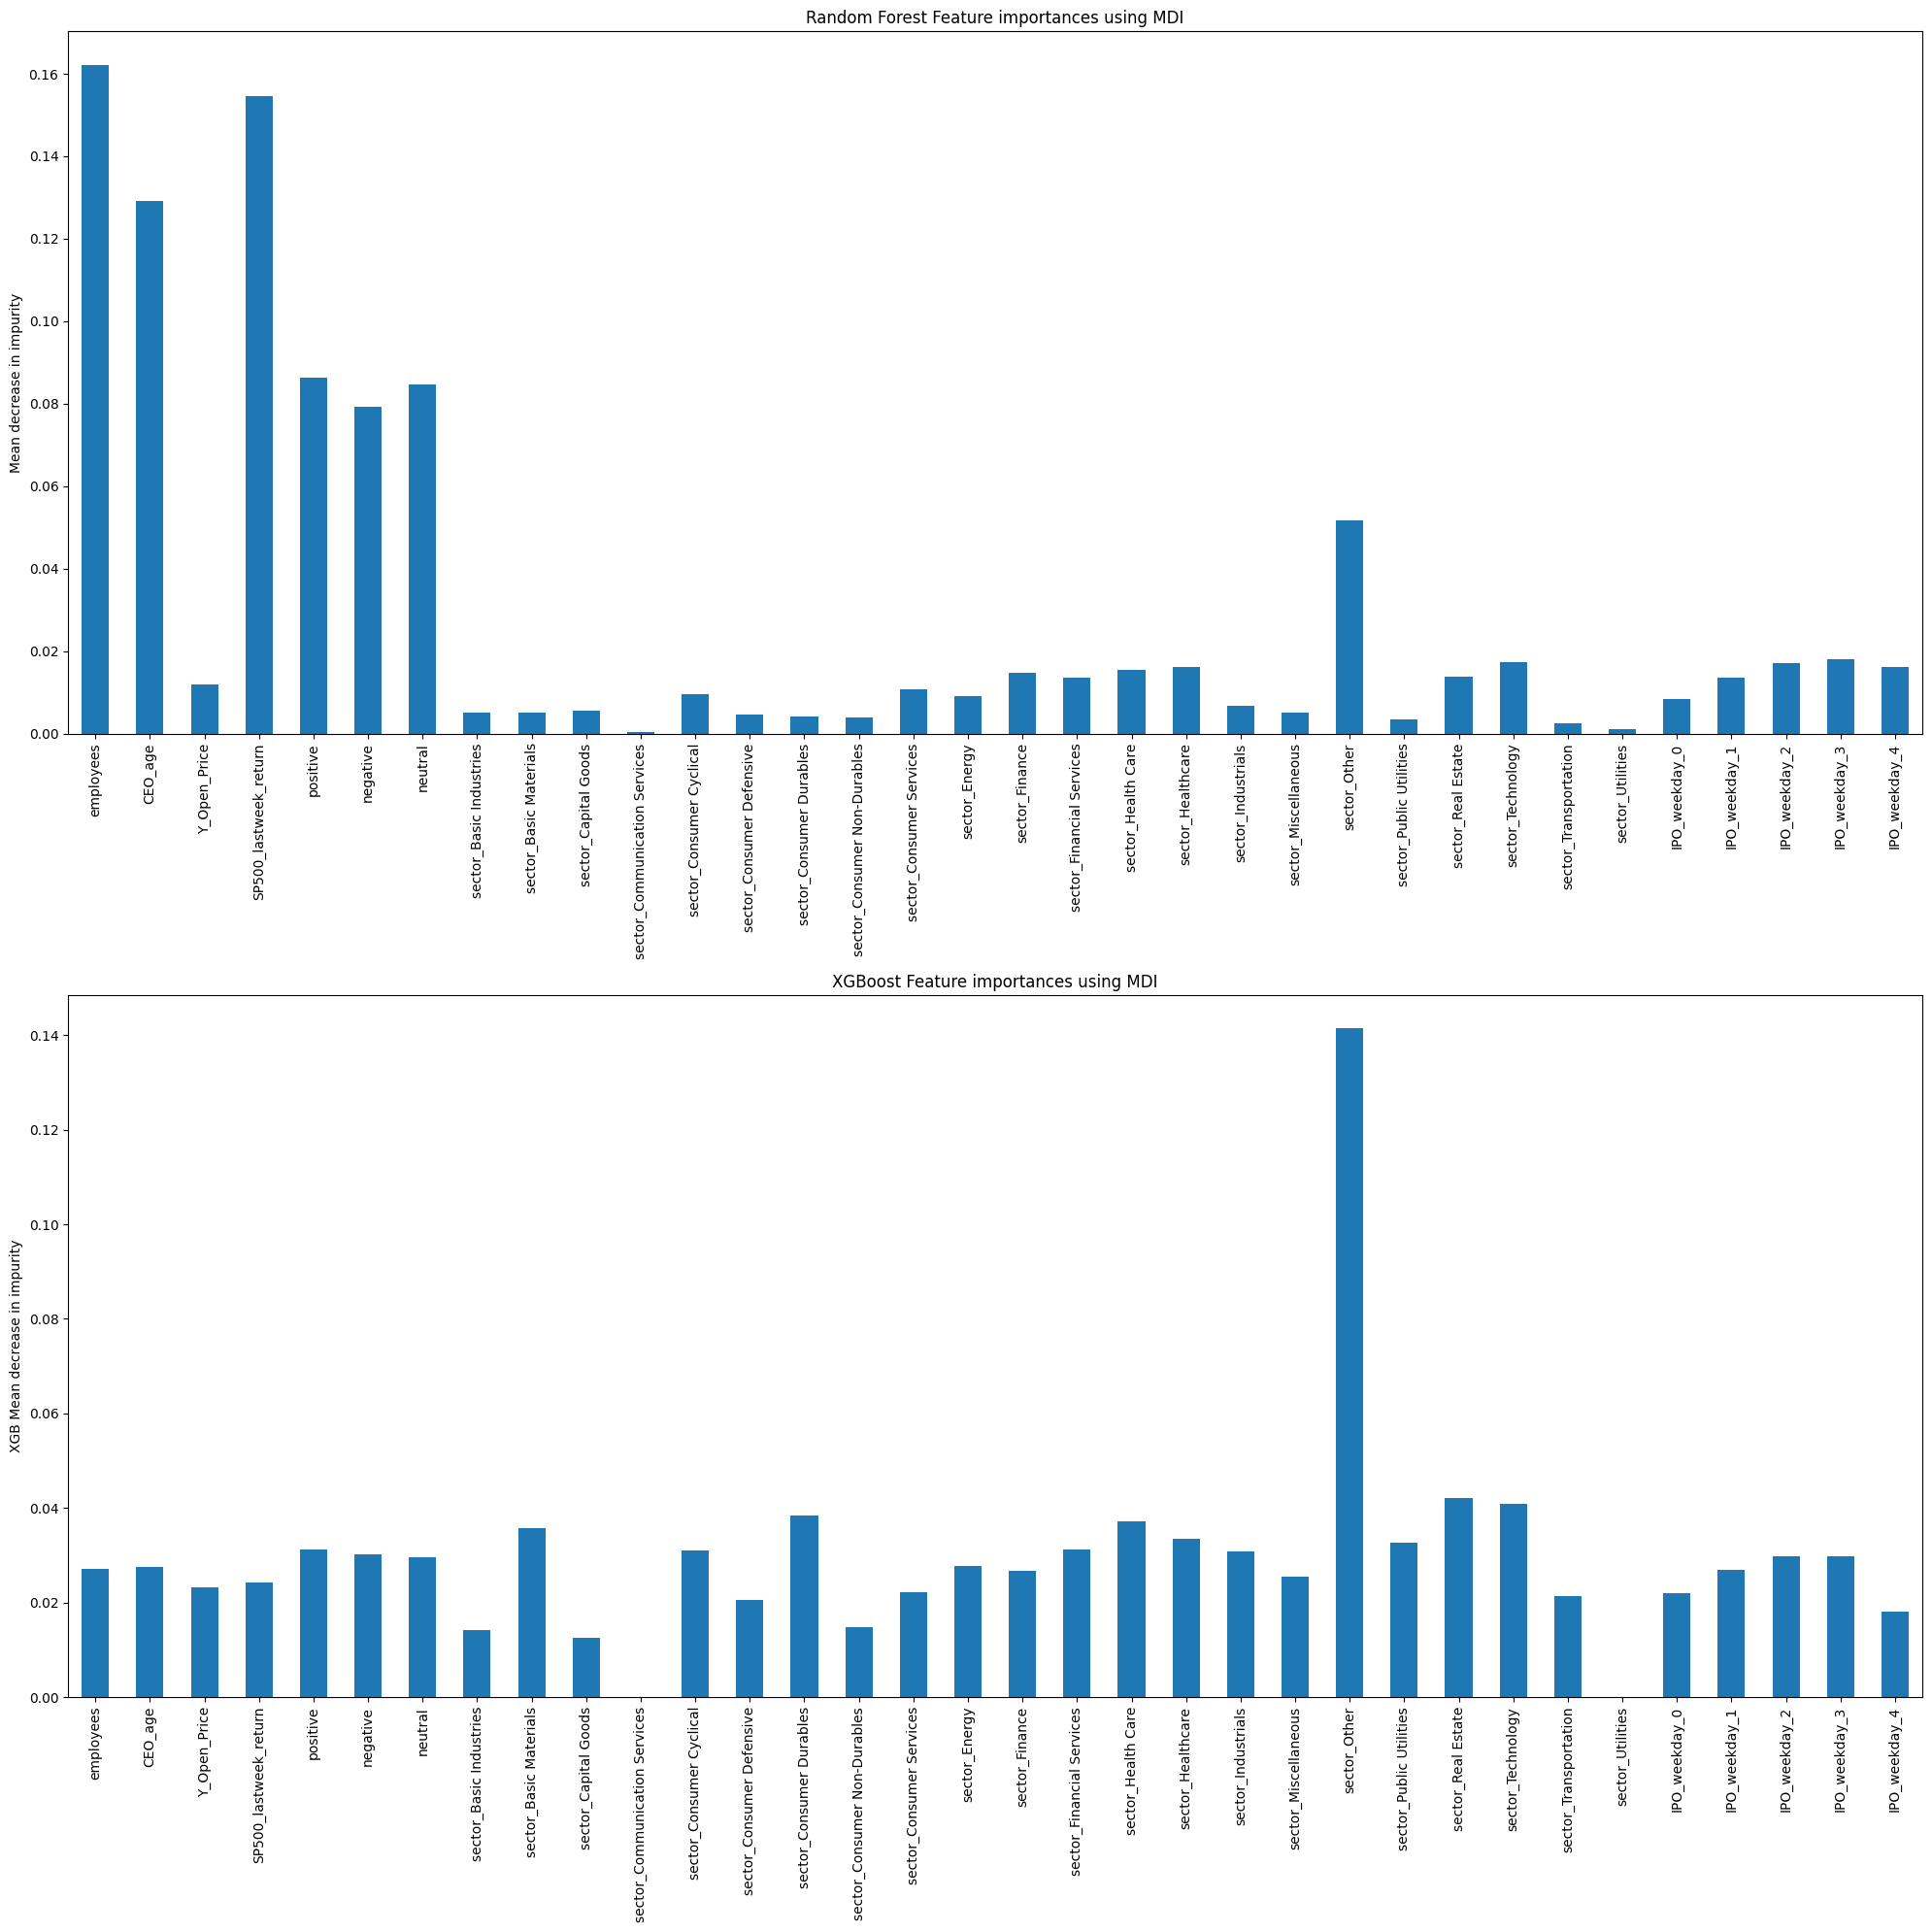

In [ ]:
#Looking at feature importances across models

#Feature importance for rf models
feature_names_d = [col for col in X_d.columns]
feature_names_w = [col for col in X_w.columns]
feature_names_m = [col for col in X_m.columns]
rf_d_importance = pd.Series(rf_random_d.best_estimator_.feature_importances_, index = feature_names_d)
rf_w_importance = pd.Series(rf_random_w.best_estimator_.feature_importances_, index = feature_names_w)
rf_m_importance = pd.Series(rf_random_m.best_estimator_.feature_importances_, index = feature_names_m)

#Feature importance for xgb models
xgb_d_importance = pd.Series(xgb_random_d.best_estimator_.feature_importances_, index = feature_names_d)
xgb_w_importance = pd.Series(xgb_random_w.best_estimator_.feature_importances_, index = feature_names_w)
xgb_m_importance = pd.Series(xgb_random_m.best_estimator_.feature_importances_, index = feature_names_m)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,20))
rf_d_importance[:10].plot.bar(ax=ax1)
xgb_d_importance[:10].plot.bar(ax = ax2)
ax1.set_title("Random Forest Feature importances using MDI")
ax1.set_ylabel("Mean decrease in impurity")
ax2.set_title("XGBoost Feature importances using MDI")
ax2.set_ylabel("XGB Mean decrease in impurity")
fig.tight_layout()


In [ ]:
xgb_d_importance.sort_values(ascending=False)

sector_Other                     0.141429
sector_Real Estate               0.042160
sector_Technology                0.040842
sector_Consumer Durables         0.038360
sector_Health Care               0.037211
sector_Basic Materials           0.035735
sector_Healthcare                0.033444
sector_Public Utilities          0.032734
sector_Financial Services        0.031243
positive                         0.031149
sector_Consumer Cyclical         0.030956
sector_Industrials               0.030879
negative                         0.030167
IPO_weekday_3                    0.029796
IPO_weekday_2                    0.029703
neutral                          0.029478
sector_Energy                    0.027734
CEO_age                          0.027622
employees                        0.027203
IPO_weekday_1                    0.026891
sector_Finance                   0.026689
sector_Miscellaneous             0.025478
SP500_lastweek_return            0.024261
Y_Open_Price                     0

In [ ]:
rf_d_importance.sort_values(ascending=False)

employees                        0.162179
SP500_lastweek_return            0.154603
CEO_age                          0.129086
positive                         0.086261
neutral                          0.084636
negative                         0.079302
sector_Other                     0.051651
IPO_weekday_3                    0.018117
sector_Technology                0.017221
IPO_weekday_2                    0.017032
IPO_weekday_4                    0.016178
sector_Healthcare                0.016027
sector_Health Care               0.015457
sector_Finance                   0.014706
sector_Real Estate               0.013671
sector_Financial Services        0.013601
IPO_weekday_1                    0.013534
Y_Open_Price                     0.011817
sector_Consumer Services         0.010606
sector_Consumer Cyclical         0.009622
sector_Energy                    0.008960
IPO_weekday_0                    0.008471
sector_Industrials               0.006600
sector_Capital Goods             0

In [ ]:
#Looking at most important features in logistic regression model
log_d_importance = pd.Series(abs(logreg_d.coef_[0]), index = X_d.columns)
log_w_importance = pd.Series(abs(logreg_w.coef_[0]), index = X_w.columns)
log_m_importance = pd.Series(abs(logreg_m.coef_[0]), index = X_m.columns)

In [ ]:
#Result aggregation

#RF results
rf_results = pd.DataFrame({'pred_label':[], 'accuracy': [], 'balanced_accuracy': [], 'top_5_features': []})
rf_results['model'] = ['RFModel']*3
rf_results.accuracy = [accuracy_score(y_d_test, rf_predictions_d), accuracy_score(y_w_test, rf_predictions_w), accuracy_score(y_m_test, rf_predictions_m)]
rf_results.balanced_accuracy = [balanced_accuracy_score(y_d_test, rf_predictions_d), balanced_accuracy_score(y_w_test, rf_predictions_w), balanced_accuracy_score(y_m_test, rf_predictions_m)]
rf_results.top_5_features = [rf_d_importance.nlargest(5).index.tolist(), rf_w_importance.nlargest(5).index.tolist(), rf_m_importance.nlargest(5).index.tolist()]
rf_results.pred_label = ['intra day underperformance', 'in-week underperformance', 'in-month underperformance']


#XGB results
xgb_results = pd.DataFrame({'pred_label':[], 'accuracy': [], 'balanced_accuracy': [], 'top_5_features': []})
xgb_results['model'] = ['XGBoost']*3
xgb_results.accuracy = [accuracy_score(y_d_test, xgb_predictions_d), accuracy_score(y_w_test, xgb_predictions_w), accuracy_score(y_m_test, xgb_predictions_m)]
xgb_results.balanced_accuracy = [balanced_accuracy_score(y_d_test, xgb_predictions_d), balanced_accuracy_score(y_w_test, xgb_predictions_w), balanced_accuracy_score(y_m_test, xgb_predictions_m)]
xgb_results.top_5_features = [xgb_d_importance.nlargest(5).index.tolist(), xgb_w_importance.nlargest(5).index.tolist(), xgb_m_importance.nlargest(5).index.tolist()]
xgb_results.pred_label = ['intra day underperformance', 'in-week underperformance', 'in-month underperformance']


#Logreg results
log_results = pd.DataFrame({'pred_label':[], 'accuracy': [], 'balanced_accuracy': [], 'top_5_features': []})
log_results['model'] = ['Logreg']*3
log_results.accuracy = [accuracy_score(y_d_test, log_pred_d), accuracy_score(y_w_test, log_pred_w), accuracy_score(y_m_test, log_pred_m)]
log_results.balanced_accuracy = [balanced_accuracy_score(y_d_test, log_pred_d), balanced_accuracy_score(y_w_test, log_pred_w), balanced_accuracy_score(y_m_test, log_pred_m)]
log_results.top_5_features = [log_d_importance.nlargest(5).index.tolist(), log_w_importance.nlargest(5).index.tolist(), log_m_importance.nlargest(5).index.tolist()]
log_results.pred_label = ['intra day underperformance', 'in-week underperformance', 'in-month underperformance']


pd.concat([rf_results, xgb_results, log_results], axis = 0)

,pred_label,accuracy,balanced_accuracy,top_5_features,model
0,intra day underperformance,0.774262,0.774262,"[employees, SP500_lastweek_return, CEO_age, po...",RFModel
1,in-week underperformance,0.763598,0.763598,"[employees, firstday_volume, SP500_lastweek_re...",RFModel
2,in-month underperformance,0.741150,0.741150,"[employees, firstday_volume, inweek_volume, SP...",RFModel
0,intra day underperformance,0.721519,0.721519,"[sector_Other, sector_Real Estate, sector_Tech...",XGBoost
1,in-week underperformance,0.757322,0.757322,"[sector_Other, sector_Basic Industries, sector...",XGBoost
2,in-month underperformance,0.767699,0.767699,"[sector_Other, sector_Healthcare, sector_Basic...",XGBoost
0,intra day underperformance,0.658228,0.658228,"[sector_Real Estate, employees, sector_Other, ...",Logreg
1,in-week underperformance,0.675732,0.675732,"[sector_Other, sector_Transportation, sector_C...",Logreg
2,in-month underperformance,0.703540,0.703540,"[sector_Other, sector_Transportation, CEO_age,...",Logreg


In [ ]:
#Evaluating performance on completely unseen validity set
rf_d_validity_predictions = best_random_rf_d.predict(X_dv)
#rf_w_validity_predictions = best_random_rf_w.predict(X_wv)
#rf_m_validity_predictions = best_random_rf_m.predict(X_mv)

xgb_d_validity_predictions = best_random_d.predict(X_dv)
#xgb_w_validity_predictions = best_random_w.predict(X_wv)
#xgb_m_validity_predictions = best_random_m.predict(X_mv)

print(balanced_accuracy_score(rf_d_validity_predictions, y_dv))
#print(balanced_accuracy_score(rf_w_validity_predictions, y_wv))
#print(balanced_accuracy_score(rf_m_validity_predictions, y_mv))

print(balanced_accuracy_score(xgb_d_validity_predictions, y_dv))
#print(balanced_accuracy_score(xgb_w_validity_predictions, y_wv))
#print(balanced_accuracy_score(xgb_m_validity_predictions, y_mv))

0.9016282225237449
0.9595238095238096
0.9020805065581186
0.8952380952380953
0.9682539682539683
0.8676542010684798


0.72